In [2]:
import tensorflow
try:
    # Python 2
    xrange
except NameError:
    # Python 3, xrange is now named range
    xrange = range
from keras.layers import Flatten, Dense, Reshape
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.callbacks import ModelCheckpoint
# Python 2 code that uses xrange(...) unchanged, and any
# range(...) replaced with list(range(...))
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

import keras
from keras.layers import Input, Dense
from keras.models import Model
from dcor import distance_correlation
from keras import losses
from keras.datasets import mnist
import numpy as np
import pandas as pd
import sys
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn import preprocessing
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
from keract import get_activations


In [3]:
 '''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
#epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

type_ae = 'dcor'
layers = 2
layersDec = 5
activation_f = keras.activations.tanh
inner_dims = 10
d_dims = 'T'
orig_dims = 784

x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [4]:
epochs = 4
#Create first input and dense layer
input_layer = Input(shape=(orig_dims,))
encoded_layer = Dense(orig_dims, activation=activation_f)(input_layer)

#Create layers - 1 dense layer
for i in xrange(layers-1):
	encoded_layer = Dense(orig_dims, activation=activation_f)(encoded_layer)

#Initialize shared hidden state layer
hidden_state = Dense(orig_dims,activation=activation_f,name='h')

#Create latent layer to output
encoded = hidden_state(encoded_layer)

#Create latent layer for decoder
encoded_output = hidden_state(encoded_layer)

#Create decoder
decoded = Dense(inner_dims, activation=activation_f)(encoded_output)
for i in xrange(layersDec-1):
	decoded = Dense(inner_dims, activation=activation_f)(decoded)

output_layer = Dense(inner_dims, activation='softplus')(decoded)

encoder = Model(input_layer, encoded)
#encoder_2 = Model(input_layer,encoded_layer)

#Wrappers for keras
def custom_loss1(y_true,y_pred):
	dcor = -1*distance_correlation(y_true,encoded)
	return dcor

def custom_loss2(y_true,y_pred):
	recon_loss = losses.categorical_crossentropy(y_true, y_pred)
	return recon_loss

if type_ae=='dcor':
	autoencoder = Model(input_layer, outputs=[encoded,output_layer])
	autoencoder.compile(optimizer='adadelta', loss=[custom_loss1, custom_loss2],
                        loss_weights=[0.6, 1],metrics=['accuracy'])
	autoencoder.fit(x_train, [x_train,y_train],
                	batch_size=batch_size,
                	epochs=epochs,
                	shuffle=True,
                	validation_data=(x_test, [x_test,y_test]),verbose=1)

else:
	autoencoder = Model(input_layer, output_layer)
	autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
	autoencoder.fit(x_train, x_train,
                	batch_size=batch_size,
                	epochs=epochs,
                	shuffle=True,
                	validation_data=(x_test, x_test))


import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test)
x_train_encoded = encoder.predict(x_train)

x2test = encoder_2.predict(x_test)
x2train =  encoder_2.predict(x_train)



Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 190s 3ms/step - loss: 0.1738 - h_loss: -2.2603 - dense_8_loss: 1.5300 - h_acc: 4.1667e-04 - dense_8_acc: 0.5161 - val_loss: -0.2743 - val_h_loss: -2.3741 - val_dense_8_loss: 1.1501 - val_h_acc: 2.0000e-04 - val_dense_8_acc: 0.7188
Epoch 2/4
60000/60000 [==============================] - 192s 3ms/step - loss: -0.5525 - h_loss: -2.6910 - dense_8_loss: 1.0621 - h_acc: 3.0000e-04 - dense_8_acc: 0.7323 - val_loss: -0.6072 - val_h_loss: -2.5547 - val_dense_8_loss: 0.9257 - val_h_acc: 1.0000e-04 - val_dense_8_acc: 0.8162
Epoch 3/4
60000/60000 [==============================] - 190s 3ms/step - loss: -0.8728 - h_loss: -2.7609 - dense_8_loss: 0.7837 - h_acc: 2.5000e-04 - dense_8_acc: 0.8244 - val_loss: -0.8949 - val_h_loss: -2.6072 - val_dense_8_loss: 0.6694 - val_h_acc: 2.0000e-04 - val_dense_8_acc: 0.8624
Epoch 4/4
60000/60000 [==============================] - 191s 3ms/step - loss: -1.11

In [19]:
x_test_encoded = autoencoder.predict(x_test)
x_train_encoded = autoencoder.predict(x_train)
print(x_test_encoded[1][0])
print(y_test[0])

[3.9402829e-04 6.1571341e-02 7.6744489e-02 4.9763642e-02 9.1227740e-02
 2.5773380e-02 2.6838263e-02 4.8295636e+00 7.8730974e-03 4.4846094e-01]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


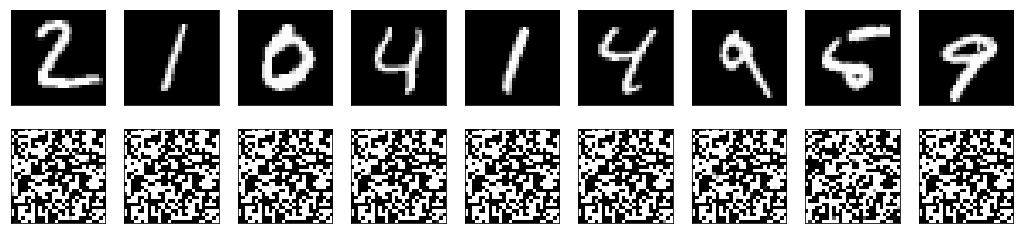

In [6]:
testPreds_1_9 = autoencoder.predict(x_test,batch_size=batch_size)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(testPreds_1_9[0][i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [7]:
scores = autoencoder.evaluate(x_test, [x_test, y_test], verbose=1)


10000/10000 [==============================] - 9s 924us/step


In [8]:
print(autoencoder.metrics_names)
scores

['loss', 'h_loss', 'dense_8_loss', 'h_acc', 'dense_8_acc']


[-0.6121964097976684, -1.8107816444396974, 0.474272620677948, 0.0007, 0.9241]

In [9]:
y_test.dtype

dtype('float32')

In [10]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import copy


def distcorr(Xval, Yval, pval=False, nruns=500):
    """ Compute the distance correlation function, returning the p-value.
    Based on Satra/distcorr.py (gist aa3d19a12b74e9ab7941)

    a = [1,2,3,4,5]
    b = np.array([1,2,9,4,4])
    distcorr(a, b)
    (0.76267624241686671, 0.404)
    """
    X = np.atleast_1d(Xval)
    Y = np.atleast_1d(Yval)
    if np.prod(X.shape) == len(X):
        X = X[:, None]
    if np.prod(Y.shape) == len(Y):
        Y = Y[:, None]
    X = np.atleast_2d(X)
    Y = np.atleast_2d(Y)
    n = X.shape[0]
    if Y.shape[0] != X.shape[0]:
        raise ValueError('Number of samples must match')
    a = squareform(pdist(X))
    b = squareform(pdist(Y))
    A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
    B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()

    dcov2_xy = (A * B).sum() / float(n * n)
    dcov2_xx = (A * A).sum() / float(n * n)
    dcov2_yy = (B * B).sum() / float(n * n)
    dcor = np.sqrt(dcov2_xy) / np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))

    if pval:
        greater = 0
        for i in range(nruns):
            Y_r = copy.copy(Yval)
            np.random.shuffle(Y_r)
            if distcorr(Xval, Y_r, pval=False) >= dcor:
                greater += 1
        return (dcor, greater / float(nruns))
    else:
        return dcor

In [11]:
a = [1,2,3,4,5]
b = np.array([1,2,9,4,4])
distcorr(x_test, y_test)

0.6529079655761683

In [12]:
distcorr(x_test_encoded[0], x_test)

0.28931375521071484

In [13]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          615440      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 784)          615440      dense_1[0][0]                    
__________________________________________________________________________________________________
h (Dense)                       (None, 784)          615440      dense_2[0][0]                    
                                                                 dense_2[0][0]                    
__________

In [10]:
filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
x_test_encodedBk = [];
for i in xrange(9999):
	x_test_encodedBk.append(x_test_encoded[0][i].reshape(784))


In [15]:
input_img = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Dense(1, activation='relu')(x)
#output_img = Activation('tanh')(x)
#In [14]:
#model = Model(input_img, output_img)
#model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
autoencoderReconst = Model(input_img,x)

In [29]:
autoencoderReconst.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
__________

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test2,marker=u'o',cmap=plt.cm.RdYlGn)
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=y_train2,marker=u'+',cmap=plt.cm.RdYlGn)
plt.colorbar()
#plt.savefig(plot_name)

from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(x2train)
x3test = pca.transform(x2test)
x3train = pca.transform(x2train)

plt.figure(figsize=(6, 6))
plt.scatter(x3test[:, 0], x3test[:, 1], c=y_test2,marker=u'o',cmap=plt.cm.RdYlGn)
plt.scatter(x3train[:, 0], x3train[:, 1], c=y_train2,marker=u'+',cmap=plt.cm.RdYlGn)
plt.colorbar()
#plt.savefig(plot_name3)

if d_dims=='T':
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(x2test[:, 0], x2test[:, 1], x2test[:,2], c=y_test2,marker=u'o')
	ax.scatter(x2train[:, 0], x2train[:, 1], x2train[:, 2], c=y_train2,marker=u'+')
#	plt.savefig(plot_name2)
	
	

autoencoder.summary()

In [ ]:
autoencoderReconst.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoderReconst.fit(x_trainEncRs, x_trainRs,
                	batch_size=batch_size,
                	epochs=epochs,
                	shuffle=True,
                	validation_data=(x_testEncRs, x_testRs))

In [38]:
x_trainRs = x_train.reshape(60000,28,28,1)
x_testRs = x_test.reshape(10000,28,28,1)
x_trainEncRs = x_train_encoded[0].reshape(60000,28,28,1)
x_testEncRs = x_test_encoded[0].reshape(10000,28,28,1)